## EXERCISE 4

We want to study the performances of an RBM, and, by looking at its learned weights and biases, better understand the correlations in the data (from file x_RBM_2024_exercise.dat, N=104 configurations with L=10 bits). Use an RBM with M=3 hidden units.

| Name | Surname | ID Number |
|------|---------|---------------------|
| Lucrezia | Rossi | 2122164 |
| Lorenzo | Calandra Buonaura | 2107761 |
| Andrea | Turci | 2106724 |

In [29]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 13

from IPython.display import display_html 
import pandas as pd

In [30]:
dname = "DATA"; fname = dname + '/x_RBM_2024_exercise.dat'

v = np.loadtxt(fname, delimiter = " ", dtype = int)
N = len(v)
L = len(v[1])
# store in v0, because later we will shuffle v
v0 = np.copy(v)
print(f'each of N={N} data has L={L} digits')
#SPINS = True
SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

each of N=10000 data has L=10 digits
each of N=10000 data has L=10 digits
[0 0 1 1 0 0 0 0 1 1]
[0 0 0 1 0 0 0 1 0 0]
[1 0 0 0 1 0 1 0 0 0]
[0 1 1 1 0 1 0 1 0 0]
[1 1 1 0 1 1 1 1 0 0]
[0 1 0 0 1 1 1 0 0 0]
[1 0 1 0 0 0 1 1 1 1]
[1 0 1 1 0 1 1 0 0 0]
[1 0 1 0 0 0 0 1 1 1]
[1 1 0 0 1 1 0 0 0 0]
[0 1 0 1 0 0 0 0 1 1]
[1 1 0 1 1 1 1 1 0 0]
...


In [31]:
def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: white;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v[:N1])
df0s = df0.style.set_table_attributes("style='display:inline'")
df0s.map(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)

display_html(df0s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9
0,0,0,1,1,0,0,0,0,1,1
1,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,1,0,0,0
3,0,1,1,1,0,1,0,1,0,0
4,1,1,1,0,1,1,1,1,0,0
5,0,1,0,0,1,1,1,0,0,0
6,1,0,1,0,0,0,1,1,1,1
7,1,0,1,1,0,1,1,0,0,0
8,1,0,1,0,0,0,0,1,1,1
9,1,1,0,0,1,1,0,0,0,0


In [32]:
# RBM, nr of hidden units
M = 3
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

w= [[-1.13551379e-01  2.65669964e-01 -2.88132757e-01]
 [-3.08263709e-01  1.09041887e+00  7.72922489e-01]
 [ 5.15360175e-02  1.56284646e-01  4.26576969e-01]
 [ 6.91397593e-01  5.58688134e-01 -7.19014104e-01]
 [ 1.52537913e-01  1.26978019e-01  7.50463234e-01]
 [ 4.91702529e-01 -1.11030861e+00 -2.06261128e-01]
 [ 9.25808667e-01 -2.43274719e-01 -2.99394686e-01]
 [ 2.64583679e-01  1.80218983e+00 -5.66475108e-01]
 [-3.20110440e-01  6.88500960e-02  1.67859802e-01]
 [ 2.90536469e-01  5.21572266e-04  7.45411556e-01]]
a= [-0.39580299 -0.46104103 -1.31476796 -1.03216437 -0.4774623   0.3107127
 -0.70221411  0.06646813 -0.58993056  0.18465011]
b= [0. 0. 0.]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1]


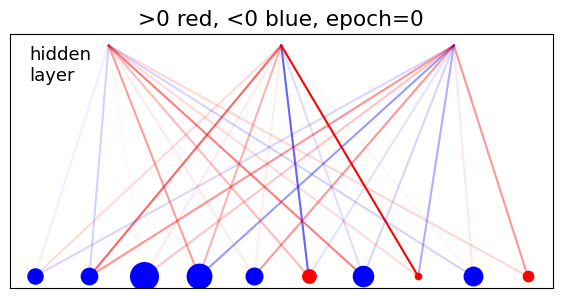

In [33]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(7, 3.3))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=300.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.51,0.85,"hidden\nlayer")
    plt.show()
                  
plotgraph()

In [34]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)
def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

k = 0
activate(v[k],w,b,GAP,info=True)

input= [0 0 1 1 0 0 0 0 1 1]
act= [0.71335964 0.78434445 0.62083422]
prob= [0.67114309 0.68661569 0.65040826]
output= [1 1 0]


array([1, 1, 0])

1.
Increase the number of contrastive divergence steps from n=1 to n=5.

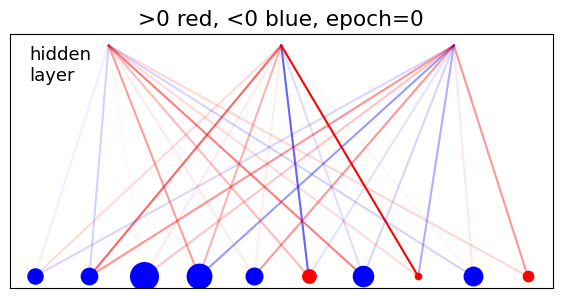

----------- epoch = 0   k= 499   m= 500
dw = [[ 0.106  0.114  0.05 ]
 [-0.066 -0.146 -0.146]
 [ 0.2    0.156  0.078]
 [ 0.112  0.068  0.052]
 [-0.01  -0.072 -0.076]
 [ 0.098  0.03  -0.032]
 [ 0.072 -0.024 -0.03 ]
 [-0.13  -0.24  -0.242]
 [ 0.144  0.13   0.082]
 [-0.14  -0.18  -0.156]]
da = [ 0.156 -0.136  0.21   0.122 -0.03   0.06   0.046 -0.25   0.188 -0.184]
db = [ 0.058 -0.066 -0.104]
----------- epoch = 1   k= 499   m= 500
dw = [[ 0.00594059  0.00594059  0.01386139]
 [-0.06336634 -0.06336634 -0.04158416]
 [-0.00792079  0.0019802  -0.04554455]
 [-0.09306931 -0.07524752 -0.04752475]
 [ 0.         -0.0019802   0.03960396]
 [ 0.04158416  0.          0.04356436]
 [-0.02376238 -0.05742574 -0.04950495]
 [-0.01980198 -0.01188119 -0.05742574]
 [-0.05346535 -0.02772277  0.        ]
 [-0.05544554 -0.00792079 -0.04752475]]
da = [ 0.02376238 -0.04356436  0.03366337 -0.06930693  0.05346535  0.05940594
 -0.02178218  0.00792079  0.0019802  -0.02772277]
db = [-0.03762376 -0.03564356 -0.03564356]


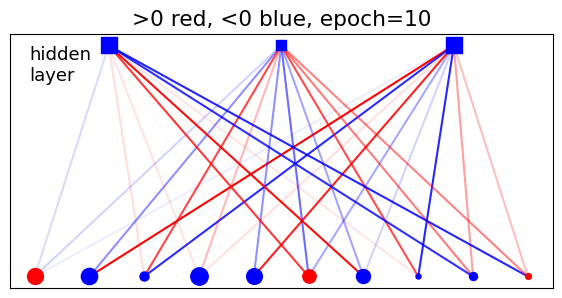

l_rate =  0.9090909090909092


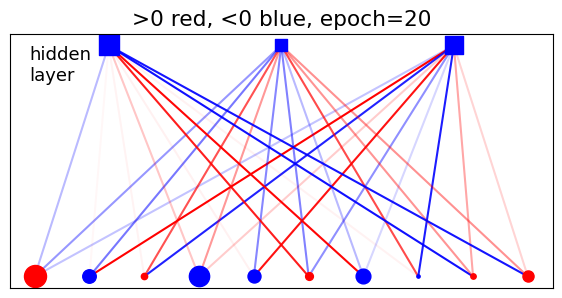

l_rate =  0.8333333333333337


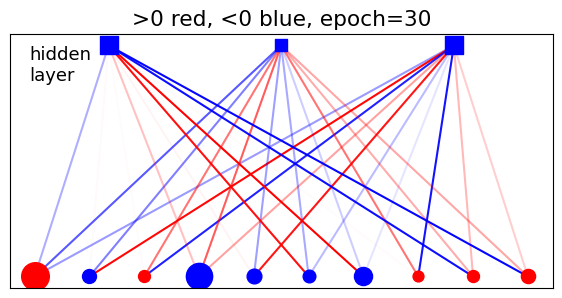

l_rate =  0.7692307692307697


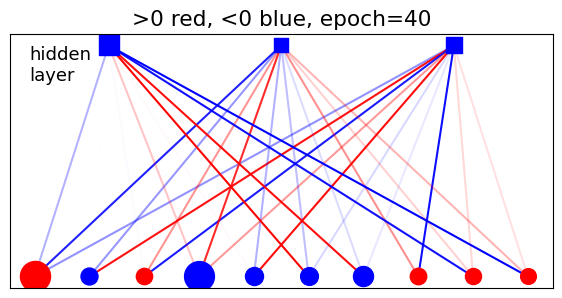

l_rate =  0.7142857142857149


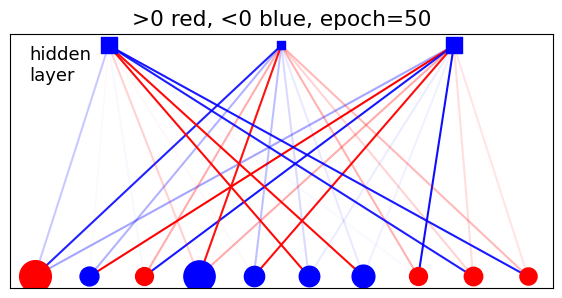

l_rate =  0.6666666666666671


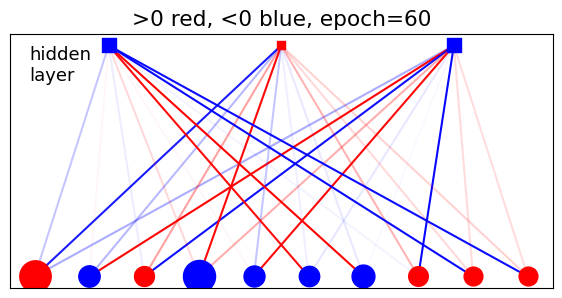

l_rate =  0.6250000000000006


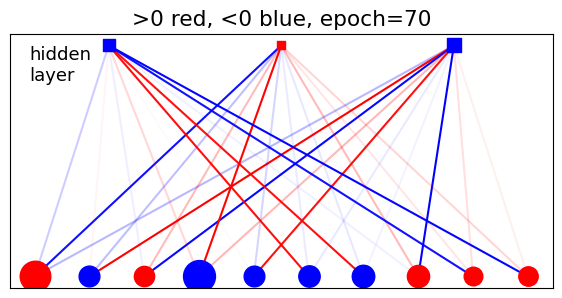

l_rate =  0.5882352941176475


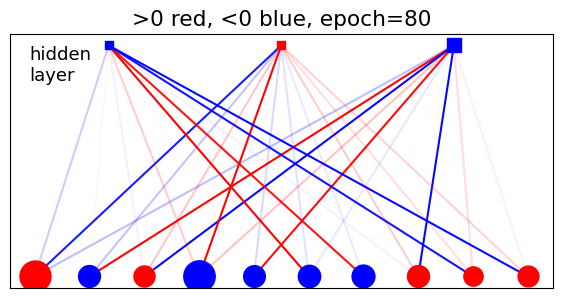

l_rate =  0.555555555555556


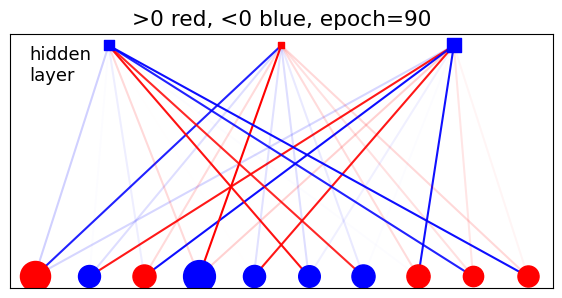

l_rate =  0.5263157894736847


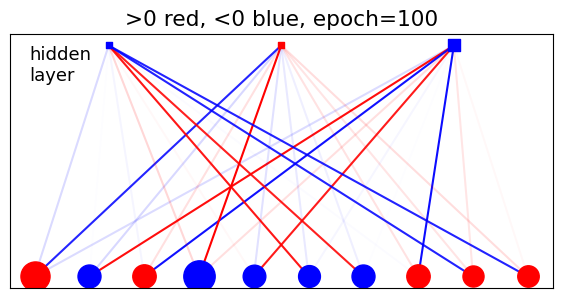

l_rate =  0.5000000000000009


In [7]:
# random seed for reproducibility
np.random.seed(12345)

plotgraph(0)

# learning rate
l_rate = 1.0

# minibatch
mini, m = 500, 0

# number of CD steps
n_steps = 5

# train model
print('===================================================')
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate in l_rate_m
    l_rate_m = l_rate / mini
    for k in range(N):
        if m == 0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))
        
        # Perform CD steps
        for step in range(n_steps):
            # positive CD phase: generating h 
            h = activate(v[k], w, b, GAP)
            # negative CD phase: generating fantasy vf
            vf = activate(h, w.T, a, GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf, w, b, GAP)
        
        v_data += v[k]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[k].T, h)
        vh_model += np.outer(vf.T, hf)
    
        m += 1
        # minibatch
        if m == mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            dw = l_rate_m * (vh_data - vh_model)
            da = l_rate_m * (v_data - v_model)
            db = l_rate_m * (h_data - h_model)
            if epoch <= 1 and k <= mini:
                print('----------- epoch =', epoch, '  k=', k, '  m=', m)
                print('dw =', dw)
                print('da =', da)
                print('db =', db)
            # basic step of vanilla gradient descent, from eq.(211)
            w = w + dw
            a = a + da
            b = b + db
            m = 0
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch % 10 == 9:
        plotgraph(epoch + 1)
        print('l_rate = ', l_rate)

### Answer 1:

### 2\.
Compute the log-likelihood L  during the training, at every epoch, or every minibatch update if it 
reaches a maximum already in the first epoch. Use “t” as an index of this “time”, indicating the unit 
in the figures.

In [11]:
import itertools as it
# Define a function to compute the log-likelihood
def energy(v,h,w,a,b):
    energy= -np.dot(v, a) - np.dot(h, b) - np.sum(np.dot(v, w) * h)
    return energy

def log_likelihood(data, w, a, b):
    num_samples = data.shape[0]
    avg_energy_data = 0
    # Compute the avarage energy
    for v in data:
        possible_configs_h = list(it.product([0, 1], repeat=len(b)))
        energy_sum = np.sum([energy(v, h, w, a, b) * np.exp(-energy(v, h, w, a, b)) for h in possible_configs_h])
        partition_func = np.sum([np.exp(-energy(v, h, w, a, b)) for h in possible_configs_h])
        
        # Average energy for this data point
        avg_energy_data += energy_sum / partition_func
    avg_energy_data /= num_samples  
    
    # Compute the partition function
    partition_func = 0
    for v in it.product([0, 1], repeat=data.shape[1]):
        for h in it.product([0, 1], repeat=len(b)):
            partition_func += np.exp(-energy(v, h, w, a, b))
    
    # Compute log-likelihood
    log_likelihood = -avg_energy_data - np.log(partition_func)
    
    return log_likelihood

# Initialize a list to store log-likelihood values
log_likelihoods = []

# Train model
print('===================================================')
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate in l_rate_m
    l_rate_m = l_rate / mini
    for k in range(N):  # Iterate over each data point
        if m == 0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))
        
        # positive CD phase: generating h 
        h = activate(v[k],w,b,GAP)
        i = 0
        hf = h
        while i < n_steps:
            # negative CD phase: generating fantasy vf
            vf = activate(hf,w.T,a,GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,w,b,GAP)
            i += 1
        
        v_data += v[k]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[k].T, h)
        vh_model += np.outer(vf.T, hf)
    
        m += 1
        # minibatch
        if m == mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            dw = l_rate_m * (vh_data - vh_model)
            da = l_rate_m * (v_data - v_model)
            db = l_rate_m * (h_data - h_model)
            if epoch <= 1 and k <= mini:
                print('----------- epoch =', epoch, '  k=', k, '  m=', m)
                print('dw =', dw)
                print('da =', da)
                print('db =', db)
            # basic step of vanilla gradient descent, from eq.(211)
            w = w + dw
            a = a + da
            b = b + db
            m = 0
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    
    # Compute log-likelihood and store it
    ll = log_likelihood(v, w, a, b)
    log_likelihoods.append(ll)
    '''
    if epoch % 10 == 9:
        plotgraph(epoch + 1)
        print('l_rate = ', l_rate)
        print('Log-likelihood at epoch {}: {}'.format(epoch + 1, ll))
        '''

----------- epoch = 0   k= 499   m= 500
dw = [[-0.00295567  0.01182266  0.00591133]
 [-0.0137931  -0.00295567  0.00295567]
 [-0.02857143 -0.00394089  0.00985222]
 [-0.01970443 -0.00492611  0.01674877]
 [-0.00492611  0.00985222  0.00689655]
 [-0.01970443 -0.00295567  0.00295567]
 [-0.0137931  -0.01280788  0.00689655]
 [-0.0137931  -0.00394089  0.00788177]
 [-0.00492611  0.00689655  0.00394089]
 [-0.01182266  0.00788177  0.02955665]]
da = [ 0.0137931  -0.00591133 -0.008867    0.00591133  0.01477833 -0.00689655
 -0.01477833 -0.00197044  0.00098522  0.0137931 ]
db = [-0.03152709 -0.00295567  0.0226601 ]
----------- epoch = 1   k= 499   m= 500
dw = [[ 0.00098039 -0.0127451  -0.00490196]
 [ 0.02941176  0.00784314  0.01078431]
 [ 0.00294118 -0.0127451  -0.00686275]
 [ 0.02156863  0.00490196  0.01372549]
 [ 0.01176471  0.00294118  0.00294118]
 [ 0.00882353 -0.00294118  0.01666667]
 [ 0.02843137 -0.00392157  0.01960784]
 [ 0.0127451   0.00784314  0.0254902 ]
 [ 0.01862745  0.0127451   0.0205882

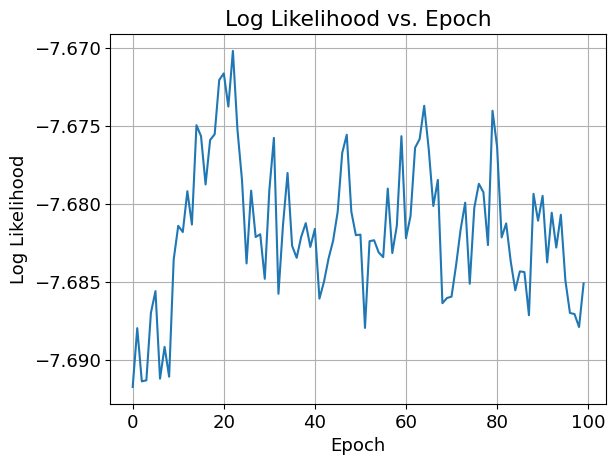

In [12]:
# Plot log likelihood vs. epoch
plt.plot(range(len(log_likelihoods)), log_likelihoods)
plt.xlabel('Epoch')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood vs. Epoch')
plt.grid(True)
plt.show()

In [13]:
# Initialize a list to store log-likelihood values
log_likelihoods = []

# Train model
print('===================================================')
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate in l_rate_m
    l_rate_m = l_rate / mini
    for k in range(N):  # Iterate over each data point
        if m == 0:
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L, M)), np.zeros((L, M))
        
        # positive CD phase: generating h 
        h = activate(v[k],w,b,GAP)
        i = 0
        hf = h
        while i < n_steps:
            # negative CD phase: generating fantasy vf
            vf = activate(hf,w.T,a,GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = activate(vf,w,b,GAP)
            i += 1
        
        v_data += v[k]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[k].T, h)
        vh_model += np.outer(vf.T, hf)
    
        m += 1
        # minibatch
        if m == mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            dw = l_rate_m * (vh_data - vh_model)
            da = l_rate_m * (v_data - v_model)
            db = l_rate_m * (h_data - h_model)
            if epoch <= 1 and k <= mini:
                print('----------- epoch =', epoch, '  k=', k, '  m=', m)
                print('dw =', dw)
                print('da =', da)
                print('db =', db)
            # basic step of vanilla gradient descent, from eq.(211)
            w = w + dw
            a = a + da
            b = b + db
            m = 0
    
            # Compute log-likelihood and store it after each minibatch update
            ll = log_likelihood(v, w, a, b)
            log_likelihoods.append(ll)
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    l_rate = l_rate / (0.01 * l_rate + 1)
    print('Epoch:', epoch, 'Log Likelihood:', ll)

----------- epoch = 0   k= 499   m= 500
dw = [[-0.02046205 -0.02178218 -0.00594059]
 [-0.0039604  -0.00330033  0.01056106]
 [-0.00990099 -0.02244224 -0.00264026]
 [-0.00726073 -0.01716172  0.00264026]
 [ 0.01518152  0.00462046  0.02838284]
 [-0.00726073 -0.00264026  0.01254125]
 [-0.00330033 -0.00330033  0.00924092]
 [-0.01188119 -0.01518152  0.0039604 ]
 [ 0.         -0.01386139 -0.00066007]
 [ 0.00066007 -0.01452145  0.00066007]]
da = [-0.02046205  0.00660066 -0.01518152 -0.01452145  0.02772277  0.
  0.00330033 -0.01518152 -0.00066007  0.00792079]
db = [-0.00924092 -0.01980198  0.01914191]
Epoch: 0 Log Likelihood: -7.686252600839747
----------- epoch = 1   k= 499   m= 500
dw = [[-0.01184211  0.00592105  0.        ]
 [-0.01513158  0.00394737  0.00197368]
 [-0.00921053  0.01644737  0.00592105]
 [-0.00921053 -0.00131579  0.00789474]
 [-0.01381579  0.01315789  0.00460526]
 [-0.01644737  0.00065789  0.00986842]
 [-0.0125      0.          0.00131579]
 [-0.01315789 -0.00197368 -0.00526316]


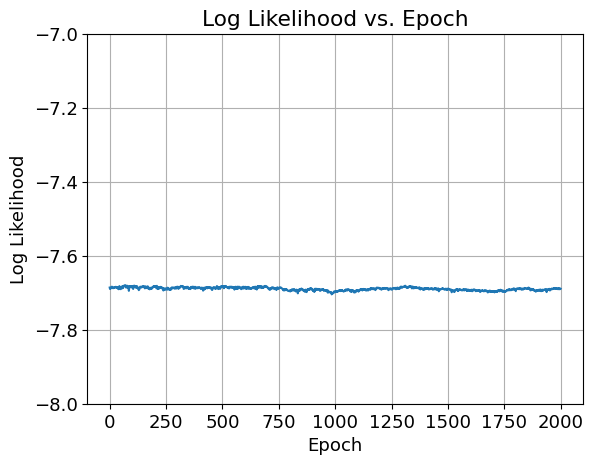

In [15]:
# Plot log likelihood vs. epoch
plt.plot(range(len(log_likelihoods)), log_likelihoods)
plt.xlabel('Epoch')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood vs. Epoch')
plt.ylim(-8,-7)
plt.grid(True)
plt.show()

### Answer 2:

5.
Try RBMs with different numbers of hidden units: M=1, 2, 3 (done above), 4, 5, and 6.

In [45]:
class RBM:
    def __init__(self, L, M, GAP=1.0):
        self.L = L  # Number of visible units
        self.M = M  # Number of hidden units
        self.GAP = GAP  # Parameter for activation function
        self.sigma = np.sqrt(4. / float(L + M))  # Range of initial weight
        self.w = None  # Weight matrix
        self.a = None  # Visible bias
        self.b = None  # Hidden bias
        

    def _initialize_weights(self):
        np.random.seed(12345)
        self.w = self.sigma * np.random.randn(self.L, self.M)
        self.a = self.sigma * np.random.randn(self.L)
        self.b = np.zeros(self.M)
        
        self.w0 = np.copy(self.w)
        self.a0 = np.copy(self.a)
        self.b0 = np.copy(self.b)
        
        #print("w =", self.w)
        #print("a =", self.a)
        #print("b =", self.b)

    def _energy(self, v, h):
        return -np.dot(v, self.a) - np.dot(h, self.b) - np.sum(np.dot(v, self.w) * h)
    
    def _log_likelihood(self, data):
        num_samples = data.shape[0]
        avg_energy_data = 0
        
        for v in data:
            possible_configs_h = list(it.product([0, 1], repeat=self.M))
            energy_sum = np.sum([self._energy(v, h) * np.exp(-self._energy(v, h)) for h in possible_configs_h])
            partition_func = np.sum([np.exp(-self._energy(v, h)) for h in possible_configs_h])
            
            avg_energy_data += energy_sum / partition_func
        
        avg_energy_data /= num_samples  
        
        partition_func = 0
        for v in it.product([0, 1], repeat=self.L):
            for h in it.product([0, 1], repeat=self.M):
                partition_func += np.exp(-self._energy(v, h))
        
        log_likelihood = -avg_energy_data - np.log(partition_func)
        
        return log_likelihood     

    def _activate(self, v_in, wei, bias, DeltaE, info=False):
        
        act = np.dot(v_in, wei) + bias
        n = np.shape(act)
        prob = 1. / (1. + exp(-DeltaE*act))
        v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
        v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
        if info:
            print('input=', v_in)
            print('act=',act)
            print('prob=',prob)
            print('output=',v_out)
        return v_out

    def compute_cd_steps(self, cd_steps, h_i):
        hf=h_i  #set for the sake of the loop
        for i in range(cd_steps):
            # negative CD phase: generating fantasy vf
            vf = self._activate(hf,self.w.T,self.a,self.GAP)
            # one more positive CD phase: generating fantasy h from fantasy vf 
            hf = self._activate(vf,self.w,self.b,self.GAP)
        return vf,hf
    
    def train(self, v_in, l_rate=1.0, minibatch_size=500, n_epochs=100, n_steps=5):
        N = len(v_in)
        np.random.seed(12345)
        np.random.shuffle(v_in)
        self.m = 0
        for epoch in range(n_epochs):
            l_rate_epoch = l_rate / minibatch_size
            for k in range(N):
                if self.m == 0:
                    self._initialize_minibatch()

                h = self._activate(v_in[k], self.w, self.b, GAP)
                
                vf, hf = self.compute_cd_steps(n_steps, h)

                self.v_data += v_in[k]
                self.v_model += vf
                self.h_data += h
                self.h_model += hf #correzione

                self.vh_data += np.outer(v_in[k].T, h)
                self.vh_model += np.outer(vf.T, hf)   #correzione

                self.m += 1

                if self.m == minibatch_size:
                    dw = l_rate_epoch * (self.vh_data - self.vh_model)
                    da = l_rate_epoch * (self.v_data - self.v_model)
                    db = l_rate_epoch * (self.h_data - self.h_model)

                    #if epoch<=1 and k<=mini:
                        #print('----------- epoch =',epoch,'  k=',k,'  m=',m)
                        #print('dw =',dw)
                        #print('da =',da)
                        #print('db =',db)
                    
                    self.w += dw
                    self.a += da
                    self.b += db
                    
                    self.m = 0 #correzione
                    
            np.random.shuffle(v)
            l_rate = l_rate / (0.01 * l_rate + 1)


    def _initialize_minibatch(self):
        self.v_data = np.zeros(self.L)
        self.v_model = np.zeros(self.L)
        self.h_data = np.zeros(self.M)
        self.h_model = np.zeros(self.M)
        self.vh_data = np.zeros((self.L, self.M))
        self.vh_model = np.zeros((self.L, self.M))

    def plot_graph(self, epoch=0):
        fig, ax = plt.subplots(1, 1, figsize=(7, 3.3))
        ax.tick_params(left=False, bottom=False)
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

        x1 = [0] * self.L
        y1 = list(range(self.L))
        for i in range(self.L):
            y1[i] = 1 * (y1[i] / (self.L - 1.) - 0.5)
            
        x2 = [1] * self.L
        y2 = list(range(self.L))
        for i in range(self.L):
            y2[i] = 0.7 * (y2[i] / (self.L - 1.) - 0.5)
            
        A = 1. / max(self.w.max(), -self.w.min())
        for i in range(self.L):
            for j in range(self.M):
                ex, ey, col = (y1[i], y2[j]), (x1[i], x2[j]), self._my_color(self.w[i][j])
                ax.plot(ex, ey, col, zorder=1, alpha=A * abs(self.w[i][j]))

        A = 300.
        for i in range(self.L):
            ax.scatter(y1[i], x1[i], s=A * abs(self.a[i]), zorder=2, c=self._my_color(self.a[i]))

        for j in range(self.M):
            ax.scatter(y2[j], x2[j], s=min(300, A * abs(self.b[j])), zorder=2, c=self._my_color(self.b[j]),
                       marker="s")
        ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
        ax.text(-0.51, 0.85, "hidden\nlayer")
        plt.show()

    @staticmethod
    def _my_color(val):
        if val > 0:
            return 'red'
        elif val < 0:
            return 'blue'
        else:
            return 'black'

w = [[-1.13551379e-01  2.65669964e-01 -2.88132757e-01]
 [-3.08263709e-01  1.09041887e+00  7.72922489e-01]
 [ 5.15360175e-02  1.56284646e-01  4.26576969e-01]
 [ 6.91397593e-01  5.58688134e-01 -7.19014104e-01]
 [ 1.52537913e-01  1.26978019e-01  7.50463234e-01]
 [ 4.91702529e-01 -1.11030861e+00 -2.06261128e-01]
 [ 9.25808667e-01 -2.43274719e-01 -2.99394686e-01]
 [ 2.64583679e-01  1.80218983e+00 -5.66475108e-01]
 [-3.20110440e-01  6.88500960e-02  1.67859802e-01]
 [ 2.90536469e-01  5.21572266e-04  7.45411556e-01]]
a = [-0.39580299 -0.46104103 -1.31476796 -1.03216437 -0.4774623   0.3107127
 -0.70221411  0.06646813 -0.58993056  0.18465011]
b = [0. 0. 0.]


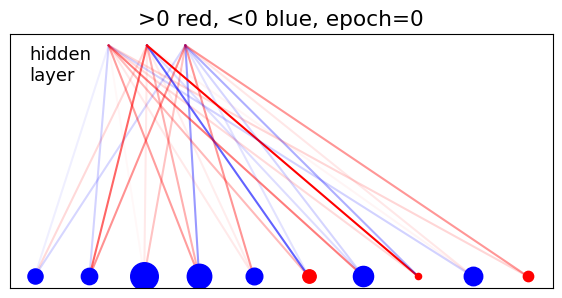

----------- epoch = 0   k= 499   m= 0
dw = [[ 0.024  0.04   0.028]
 [-0.13  -0.158 -0.076]
 [ 0.174  0.168  0.104]
 [ 0.06   0.042  0.046]
 [-0.018  0.008  0.018]
 [ 0.052  0.044 -0.016]
 [ 0.07   0.056 -0.01 ]
 [-0.192 -0.232 -0.22 ]
 [ 0.068  0.084  0.09 ]
 [-0.186 -0.14  -0.116]]
da = [ 0.072 -0.142  0.234  0.084  0.022  0.052  0.086 -0.27   0.144 -0.202]
db = [-0.032 -0.026 -0.04 ]
----------- epoch = 1   k= 499   m= 0
dw = [[ 0.04158416  0.0019802  -0.00792079]
 [ 0.03168317 -0.02376238  0.04356436]
 [ 0.04752475  0.01386139 -0.03366337]
 [ 0.03366337 -0.00990099  0.02178218]
 [ 0.00990099 -0.02772277  0.02178218]
 [ 0.04158416 -0.0039604  -0.02376238]
 [ 0.0990099   0.1049505   0.05148515]
 [ 0.01782178  0.01980198 -0.02376238]
 [-0.01386139 -0.03366337 -0.02574257]
 [ 0.00990099  0.01782178  0.00990099]]
da = [ 0.00990099 -0.02376238  0.01980198  0.01980198 -0.02178218  0.0019802
  0.11683168 -0.00990099 -0.05544554  0.01980198]
db = [0.07128713 0.00594059 0.        ]


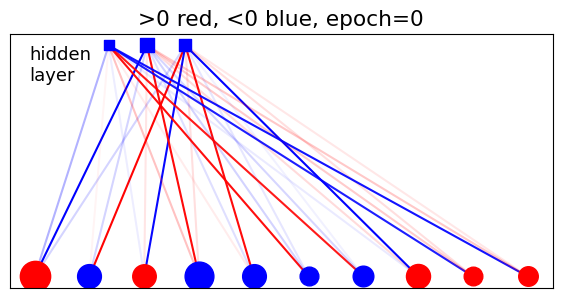

In [21]:
# Create RBM instance
rbm = RBM(L, M, GAP)

# Plot graph
rbm._initialize_weights()  # Initialize weights
rbm.plot_graph()

# Example usage: train RBM
rbm.train(v)

# Plot graph after training
rbm.plot_graph()

Training RBM with 1 hidden units...
w = [[-0.12344336]
 [ 0.2888137 ]
 [-0.31323333]
 [-0.33511798]
 [ 1.18541029]
 [ 0.84025533]
 [ 0.05602556]
 [ 0.16989932]
 [ 0.46373806]
 [ 0.75162843]]
a = [ 0.60735803 -0.78165074  0.16582619  0.13803966  0.81583955  0.534537
 -1.20703271 -0.22422949  1.00646013 -0.2644675 ]
b = [0.]
----------- epoch = 0   k= 499   m= 0
dw = [[-0.184]
 [ 0.046]
 [-0.068]
 [-0.032]
 [-0.364]
 [-0.252]
 [ 0.162]
 [-0.052]
 [-0.318]
 [-0.102]]
da = [-0.126  0.1    0.052  0.072 -0.352 -0.218  0.272  0.044 -0.29  -0.038]
db = [-0.148]
----------- epoch = 1   k= 499   m= 0
dw = [[-0.02772277]
 [ 0.00792079]
 [-0.05742574]
 [ 0.01584158]
 [-0.0019802 ]
 [-0.01386139]
 [-0.00990099]
 [-0.06336634]
 [-0.02772277]
 [-0.03564356]]
da = [-0.02376238 -0.0019802  -0.00792079  0.03366337 -0.01188119  0.01782178
  0.03762376 -0.0039604  -0.00594059 -0.04554455]
db = [-0.03960396]


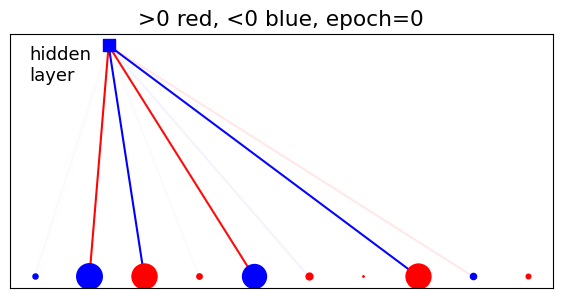

Training RBM with 2 hidden units...
w = [[-0.11818802  0.27651807]
 [-0.29989808 -0.32085104]
 [ 1.13494394  0.80448323]
 [ 0.05364039  0.16266622]
 [ 0.44399539  0.71962943]
 [ 0.58150105 -0.74837361]
 [ 0.15876649  0.13216291]
 [ 0.7811069   0.51178022]
 [-1.15564584 -0.21468339]
 [ 0.96361221 -0.25320836]]
a = [-3.11619869e-01  2.75387424e-01  1.87577865e+00 -5.89605986e-01
 -3.33181510e-01  7.16614519e-02  1.74714021e-01  3.02399945e-01
  5.42869627e-04  7.75848946e-01]
b = [0. 0.]
----------- epoch = 0   k= 499   m= 0
dw = [[-0.052 -0.032]
 [-0.05  -0.018]
 [-0.474 -0.352]
 [ 0.008  0.014]
 [-0.238 -0.19 ]
 [-0.032 -0.04 ]
 [-0.156 -0.138]
 [-0.306 -0.272]
 [ 0.176  0.156]
 [-0.306 -0.27 ]]
da = [ 0.05   0.046 -0.466  0.086 -0.17   0.046 -0.13  -0.286  0.314 -0.278]
db = [-0.146 -0.128]
----------- epoch = 1   k= 499   m= 0
dw = [[-0.02970297 -0.00594059]
 [ 0.01584158  0.01188119]
 [ 0.02178218  0.01782178]
 [-0.01584158  0.00990099]
 [-0.01980198 -0.0039604 ]
 [ 0.00594059  0.01

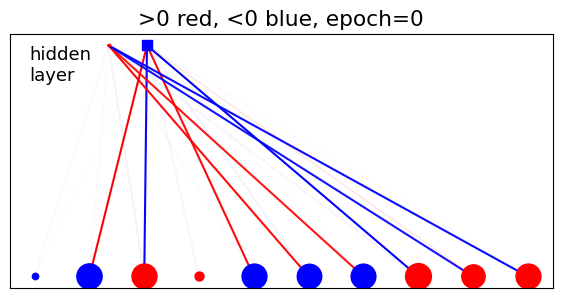

Training RBM with 4 hidden units...
w = [[-1.09420847e-01  2.56005983e-01 -2.77651672e-01 -2.97050343e-01]
 [ 1.05075391e+00  7.44806747e-01  4.96613490e-02  1.50599653e-01]
 [ 4.11059853e-01  6.66247391e-01  5.38365357e-01 -6.92859327e-01]
 [ 1.46989211e-01  1.22359081e-01  7.23164467e-01  4.73816413e-01]
 [-1.06992015e+00 -1.98758197e-01  8.92131554e-01 -2.34425385e-01]
 [-2.88503938e-01  2.54959213e-01  1.73663357e+00 -5.45869073e-01]
 [-3.08466139e-01  6.63456126e-02  1.61753753e-01  2.79967947e-01]
 [ 5.02599612e-04  7.18296549e-01 -3.81405303e-01 -4.44270254e-01]
 [-1.26694211e+00 -9.94618479e-01 -4.60094183e-01  2.99410253e-01]
 [-6.76670449e-01  6.40502923e-02 -5.68471315e-01  1.77933296e-01]]
a = [-1.2611624  -0.1066602  -0.82423128 -0.51888017 -0.69863706  0.15306038
  0.20204101 -0.4029693   0.17707963  0.72146756]
b = [0. 0. 0. 0.]
----------- epoch = 0   k= 499   m= 0
dw = [[ 0.048  0.184  0.14   0.1  ]
 [-0.2   -0.206 -0.206 -0.082]
 [-0.084 -0.016 -0.052  0.01 ]
 [-0.094

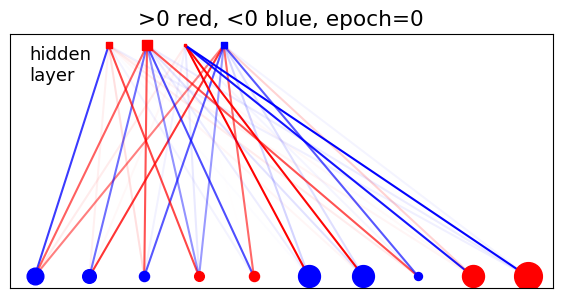

Training RBM with 5 hidden units...
w = [[-1.05710581e-01  2.47325276e-01 -2.68236999e-01 -2.86977895e-01
   1.01512472e+00]
 [ 7.19551678e-01  4.79774212e-02  1.45493088e-01  3.97121546e-01
   6.43656130e-01]
 [ 5.20110348e-01 -6.69365702e-01  1.42005069e-01  1.18210102e-01
   6.98643250e-01]
 [ 4.57750143e-01 -1.03364106e+00 -1.92018661e-01  8.61880964e-01
  -2.26476438e-01]
 [-2.78721284e-01  2.46314000e-01  1.67774743e+00 -5.27359626e-01
  -2.98006602e-01]
 [ 6.40959511e-02  1.56268971e-01  2.70474733e-01  4.85557355e-04
   6.93940393e-01]
 [-3.68472529e-01 -4.29205842e-01 -1.22398236e+00 -9.60892739e-01
  -4.44493209e-01]
 [ 2.89257786e-01 -6.53725760e-01  6.18784611e-02 -5.49195467e-01
   1.71899895e-01]
 [-1.21839863e+00 -1.03043539e-01 -7.96283067e-01 -5.01285870e-01
  -6.74947519e-01]
 [ 1.47870374e-01  1.95190156e-01 -3.89305333e-01  1.71075174e-01
   6.97003882e-01]]
a = [ 0.03608417  0.12738196 -0.0061253   0.51888247  0.68536035 -0.47470463
 -0.79995512  0.01145608  0.3916

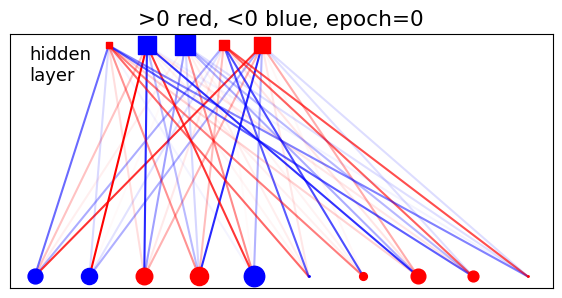

Training RBM with 6 hidden units...
w = [[-1.02353830e-01  2.39471669e-01 -2.59719358e-01 -2.77865152e-01
   9.82890286e-01  6.96702916e-01]
 [ 4.64539384e-02  1.40873076e-01  3.84511284e-01  6.23217368e-01
   5.03594679e-01 -6.48110555e-01]
 [ 1.37495817e-01  1.14456439e-01  6.76458418e-01  4.43214670e-01
  -1.00081865e+00 -1.85921269e-01]
 [ 8.34512655e-01 -2.19284868e-01 -2.69870723e-01  2.38492505e-01
   1.62447196e+00 -5.10613762e-01]
 [-2.88543652e-01  6.20606378e-02  1.51306781e-01  2.61886034e-01
   4.70138888e-04  6.71904897e-01]
 [-3.56771993e-01 -4.15576769e-01 -1.18511583e+00 -9.30380394e-01
  -4.30378699e-01  2.80072647e-01]
 [-6.32967246e-01  5.99135623e-02 -5.31756224e-01  1.66441358e-01
  -1.17970940e+00 -9.97714777e-02]
 [-7.70997764e-01 -4.85367956e-01 -6.53515125e-01  1.43174874e-01
   1.88992055e-01 -3.76943267e-01]
 [ 1.65642825e-01  6.74871107e-01  3.49383444e-02  1.23337055e-01
  -5.93080054e-03  5.02405795e-01]
 [ 6.63597307e-01 -4.59630779e-01 -7.74553219e-01  

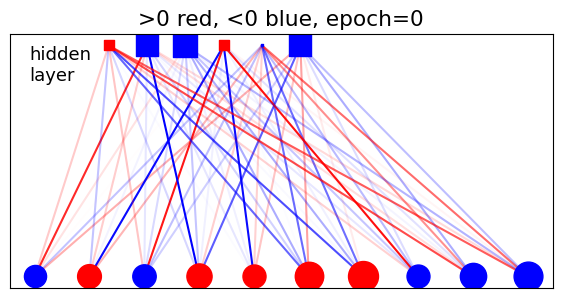

In [38]:
hidden_units = [ 1,2, 4, 5, 6]
log_likelihoods = []

for M in hidden_units:
    print(f"Training RBM with {M} hidden units...")
    rbm = RBM(L=L, M=M, GAP=GAP)  # Create RBM instance
    rbm._initialize_weights()  # Initialize weights
    rbm.train(v)  # Train RBM using loaded data
    rbm.plot_graph()  # Plot the learned features

### Answer 5:

### 3\.
for M=3, plot L  as a function of “t”, comparing the two contrastive divergence cases (n=1 and 
n=5). Then, for n=1, plot L  as a function of “t”, comparing the two cases with different M.

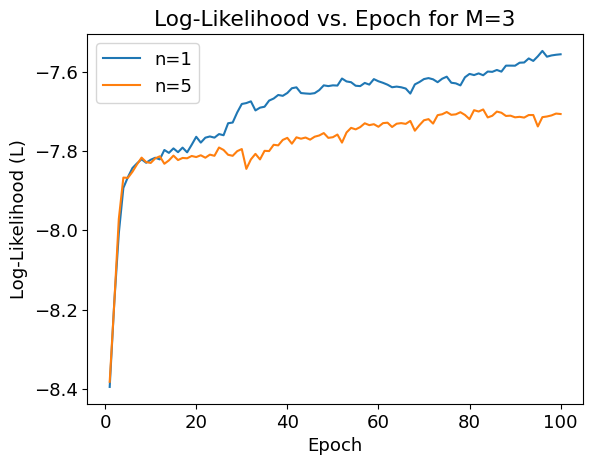

In [47]:
# Initialize RBM with M=3
rbm_n1 = RBM(L=10, M=3, GAP=1.0)
rbm_n5 = RBM(L=10, M=3, GAP=1.0)
rbm_n1._initialize_weights()
rbm_n5._initialize_weights()

# Train RBM with n=1
log_likelihoods_n1 = []
for epoch in range(100):  
    rbm_n1.train(v, n_epochs=1, n_steps=1)  
    ll_n1 = rbm_n1._log_likelihood(v)  
    log_likelihoods_n1.append(ll_n1)

# Train RBM with n=5
log_likelihoods_n5 = []
for epoch in range(100):  
    rbm_n5.train(v, n_epochs=1, n_steps=5)  
    ll_n5 = rbm_n5._log_likelihood(v)  
    log_likelihoods_n5.append(ll_n5)

# Plot log-likelihood as a function of epoch number
epochs = range(1, len(log_likelihoods_n1) + 1) 
plt.plot(epochs, log_likelihoods_n1, label='n=1')
plt.plot(epochs, log_likelihoods_n5, label='n=5')
plt.xlabel('Epoch')
plt.ylabel('Log-Likelihood (L)')
plt.title('Log-Likelihood vs. Epoch for M=3')
plt.legend()
plt.show()

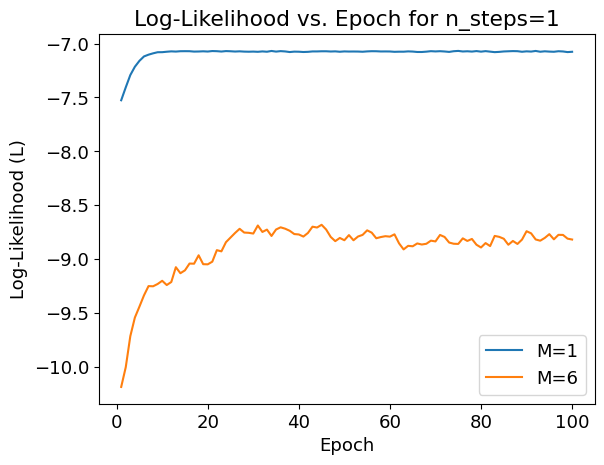

In [48]:
# Initialize RBM with different M
rbm_m1 = RBM(L=10, M=1, GAP=1.0)
rbm_m6 = RBM(L=10, M=6, GAP=1.0)
rbm_m1._initialize_weights()
rbm_m6._initialize_weights()

# Train RBM with M=1
log_likelihoods_m1 = []
for epoch in range(100):  
    rbm_m1.train(v, n_epochs=1, n_steps=1)  
    ll_m1 = rbm_m1._log_likelihood(v)  
    log_likelihoods_m1.append(ll_m1)

# Train RBM with M=6
log_likelihoods_m6 = []
for epoch in range(100):  
    rbm_m6.train(v, n_epochs=1, n_steps=1)  
    ll_m6 = rbm_m6._log_likelihood(v)  
    log_likelihoods_m6.append(ll_m6)

# Plot log-likelihood as a function of epoch number
epochs = range(1, len(log_likelihoods_n1) + 1) 
plt.plot(epochs, log_likelihoods_m1, label='M=1')
plt.plot(epochs, log_likelihoods_m6, label='M=6')
plt.xlabel('Epoch')
plt.ylabel('Log-Likelihood (L)')
plt.title('Log-Likelihood vs. Epoch for n_steps=1')
plt.legend()
plt.show()

### 4\.
From the weights learned by the RBM, guess the structure of the data

### Answer 4:
